### The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2022 Semester 2

## Assignment 1

**Student Name:**    Siu Pui Cheung

**Student ID:**     1230798

This iPython notebook is a template which you should use for your Assignment 3 submission. This file should be submitted at the **Assignment 3: Code** link on the LMS, along with any images needed to run your code.

In addition to this file, you should submit a writren report explaining your results at the **Assignment 3: Report** link on the LMS. Please see the assignment specification for details on what must be included in the report for each question.

*Adding proper comments to your code is MANDATORY.*

### 1. Load images and compute correspondences


In [1]:
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
import random

# load images
img = []
img_name = []
for name  in os.listdir('kusvod2/'):
        file = cv2.imread(os.path.join('kusvod2/', name),cv2.IMREAD_GRAYSCALE)
        if file is not None:
            img.append(file)
            img_name.append(name)
img_pair = []
for i in range(1, len(img), 2):
    img_pair.append([img[i-1], img[i]])
    
names = [img_name[i] for i in range(1, len(img_name), 2)]

In [2]:
# find keypoints
sift = cv2.SIFT_create()
kpL, kpR = [], [] 

for pair in img_pair:
    img1, img2 = pair[0], pair[1]
    # Compute SIFT keypoints and descriptors
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    # FLANN parameters and initialize
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Matching descriptor using KNN algorithm
    matches = flann.knnMatch(des1, des2, k=2)

    # Apply ratio test
    ptsL = []
    ptsR = []

    for i,(m,n) in enumerate(matches):
        if m.distance < 0.7 *n.distance: # was 0.7
            ptsL.append(kp1[m.queryIdx].pt)
            ptsR.append(kp2[m.trainIdx].pt)

    ptsL = np.int32(ptsL)
    ptsR = np.int32(ptsR)
    kpL.append(ptsL)
    kpR.append(ptsR)

### 2. Compute the Fundamental Matrix F using the 8 point algorithm

In [3]:
# a. Shift and scale the pixel coordinates
def normalise(l,r, img):
    h, w = img.shape
    
    n = len(l)
    listL, listR = [], []
    for i in range(n):
        listL.append(list(l[i]))
        listR.append(list(r[i]))        
    
    trans = np.array([[1/h, 0, 0], [0, 1/w, 0], [0, 0, 1]])

    normL = np.dot(l, trans[:2, :2])
    normR = np.dot(r, trans[:2, :2])
    kps = np.array([np.append(normL[i], normR[i]) for i in range(n)])
    
    return kps, trans

In [4]:
# b. Compute the design matrix from sets of (at least) 8 points
def design_matrix(kps):
    A = np.zeros((len(kps), 9))
    
    for i in range(len(kps)):
        A[i][0] = kps[i][0] * kps[i][2]
        A[i][1] = kps[i][1] * kps[i][2]
        A[i][2] = kps[i][2]
        A[i][3] = kps[i][0] * kps[i][3]
        A[i][4] = kps[i][1] * kps[i][3]
        A[i][5] = kps[i][3]
        A[i][6] = kps[i][0]
        A[i][7] = kps[i][1]
        A[i][8] = 1
    # c. Perform an SVD of the design matrix to find its null space
    u, s, vh = np.linalg.svd(A)
 
    # d. Compose the draft fundamental matrix F
    F = np.reshape(vh[-1], (3,3))  
    
    # e. Perform an SVD of the draft fundamental matrix
    u, s, vh = np.linalg.svd(F)
    # set the smallest singular value to zero
    s[-1] = 0
    s = np.diag(s)
    F = np.dot(u ,np.dot(s, vh))
    return F

In [5]:
# f. Calculate which correspondences are inliers
def dist(points, F):
    left = np.append(points[:2],1)
    right = np.append(points[2:],1)
    p=np.dot(F,left)
    dist = abs(right @ F @ left)
    return dist


In [6]:
# function to plot the img
# part of the epipolar line calculation refer to https://github.com/Smelton01/8-point-algorithm
def plot(img, F, pt1, pt2, left=True):
    w = img.shape[1]
    for i in range(len(pt1)):
        if left == True:
            p1, p2 = pt1[i]
            matrix = np.append(pt2[i], 1)
            x, y, z = matrix.T @ F
        else:
            p1, p2 = pt2[i]
            matrix = np.append(pt1[i], 1)
            x, y, z = F @ matrix
        
        l1 = (0, w)
        l2 = (-z/y, -(x*w+z)/y)
        plt.plot(l1,l2)
        plt.plot(p1, p2, '.')
        plt.axis('off')
    plt.imshow(img, cmap='gray')

In [7]:
import math

# g. Wrap steps b-f in a RANSAC loop 
def ransac(l, r, norm=True, thres=0.001):
    p = .99
    n_samples = 8 # no. of points for the algorithm
    ransac_iterations = round(math.log(1-p)/math.log(1-.5**n_samples)) # iteration
    best_collect = []
    for i in range(len(kpL)):
        best_points = []
        best_F = None
        best_samples = None
        if norm == True:
            points, trans = normalise(kpL[i],kpR[i],img_pair[i][0])
        else: 
            points = np.array([np.append(kpL[i][j], kpR[i][j]) for j in range(len(kpL[i]))])
        # run n times iteration to get the best results
        for j in range(ransac_iterations):
            # generate 8 samples
            x = np.random.choice(len(points), n_samples, replace=False)
            sample_points = [points[j] for j in x]
            is_inliers = []
            F = design_matrix(sample_points)

            # check the errors of every keypoints
            for idx, test_point in enumerate(points):
            #for test_point in points:
                error = dist(test_point, F)
                if error <= thres:
                    is_inliers.append(idx)
            if len(is_inliers) > len(best_points):
                if norm == True:
                    F = trans.T @ F @ trans
                best_F = F
                best_points = is_inliers
                best_samples = x
        # print the inlier ratio and plot the 8 samples
        ratio = len(best_points)/len(points)
        print(names[i], ': ', ratio)
        print('number of inliers:', len(best_points), '/', len(points))
        imgL, imgR = img_pair[i]

        pL = [kpL[i][j] for j in best_samples]
        pR = [kpR[i][j] for j in best_samples]
        plt.subplot(1,2,1)
        plot(imgL, best_F, pL, pR)
        plt.subplot(1,2,2)
        plot(imgR, best_F, pL, pR, False)
        plt.show()
        
        best_collect.append((best_points, best_F))
    return best_collect

bookshB.png :  0.9299363057324841
number of inliers: 146 / 157


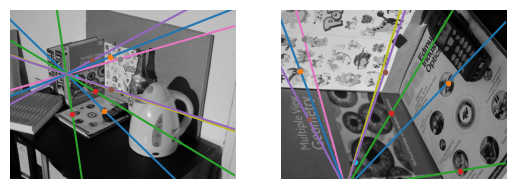

boxB.png :  0.8611111111111112
number of inliers: 155 / 180


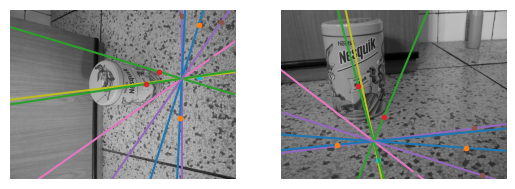

castleB.png :  0.7121212121212122
number of inliers: 141 / 198


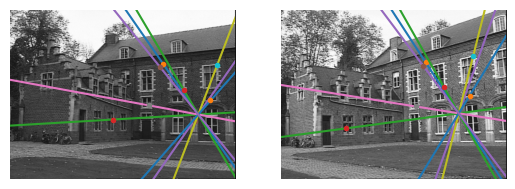

corrB.png :  0.9772727272727273
number of inliers: 387 / 396


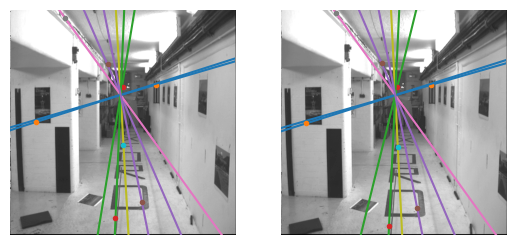

graffB.png :  0.3157894736842105
number of inliers: 12 / 38


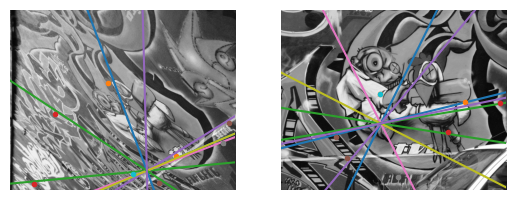

headB.jpg :  0.8853046594982079
number of inliers: 247 / 279


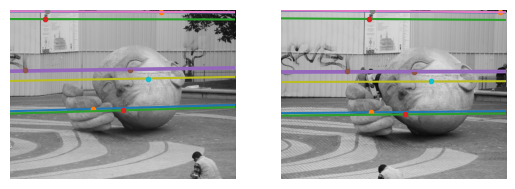

kampaB.png :  0.7910447761194029
number of inliers: 106 / 134


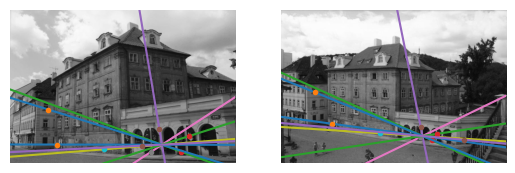

KyotoB.jpg :  0.8312551953449709
number of inliers: 1000 / 1203


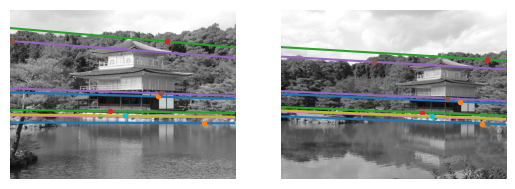

leafsB.jpg :  0.35555555555555557
number of inliers: 48 / 135


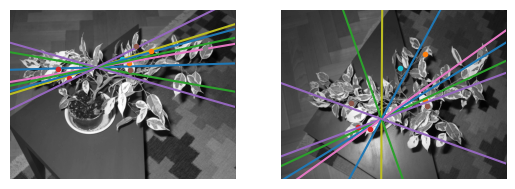

plantB.png :  0.46551724137931033
number of inliers: 81 / 174


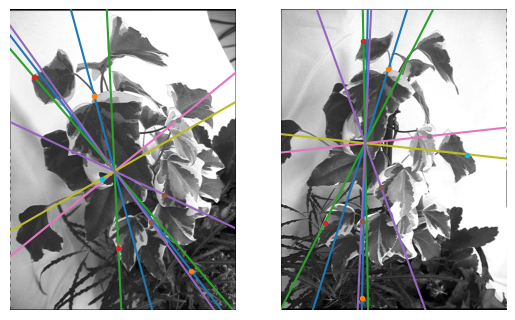

rotundaB.png :  0.7391304347826086
number of inliers: 17 / 23


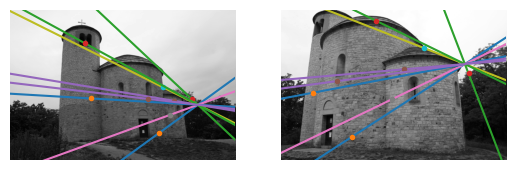

shoutB.png :  0.7567567567567568
number of inliers: 84 / 111


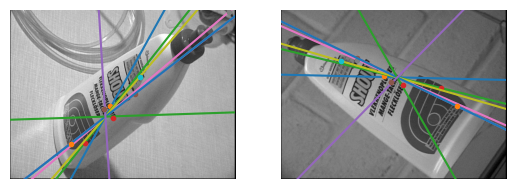

valbonneB.png :  0.8955223880597015
number of inliers: 120 / 134


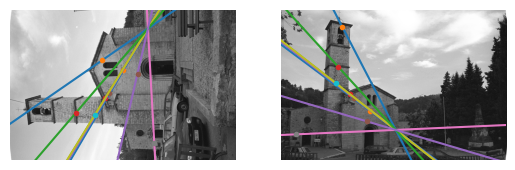

wallB.jpg :  0.8944954128440367
number of inliers: 195 / 218


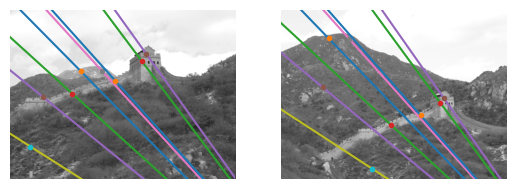

washB.png :  0.3898305084745763
number of inliers: 23 / 59


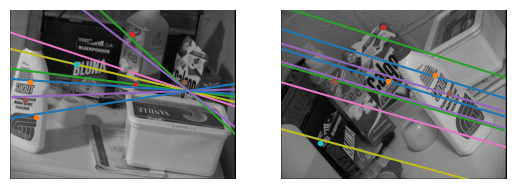

zoomB.png :  0.819672131147541
number of inliers: 150 / 183


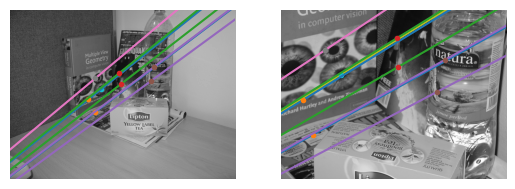

In [8]:
# test threshold of 0.001
result_norm_001 = ransac(kpL,kpR, thres=0.001)

bookshB.png :  0.9363057324840764
number of inliers: 147 / 157


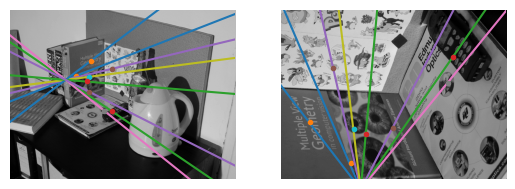

boxB.png :  0.9055555555555556
number of inliers: 163 / 180


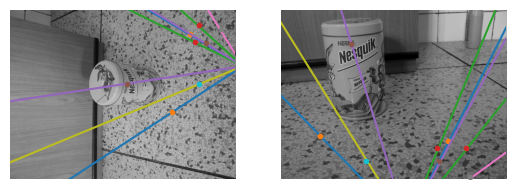

castleB.png :  0.7676767676767676
number of inliers: 152 / 198


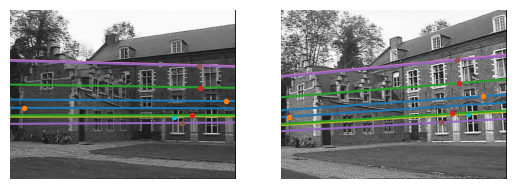

corrB.png :  0.9873737373737373
number of inliers: 391 / 396


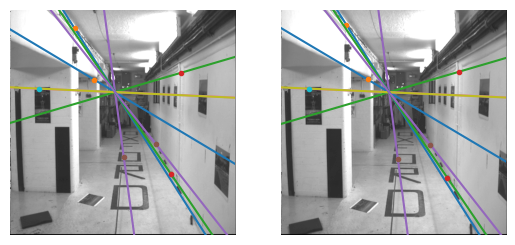

graffB.png :  0.42105263157894735
number of inliers: 16 / 38


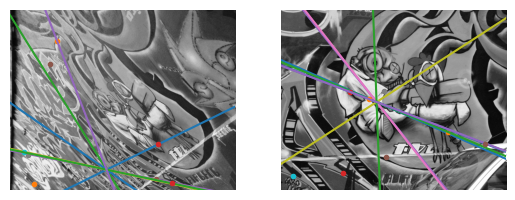

headB.jpg :  0.910394265232975
number of inliers: 254 / 279


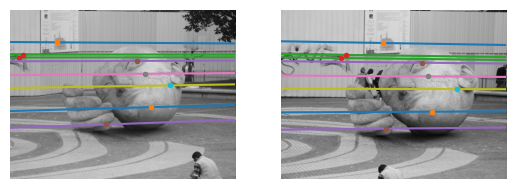

kampaB.png :  0.835820895522388
number of inliers: 112 / 134


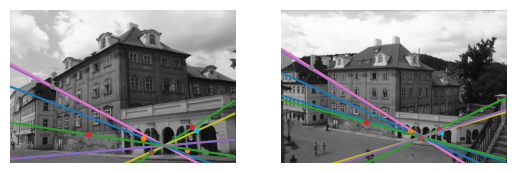

KyotoB.jpg :  0.8811305070656692
number of inliers: 1060 / 1203


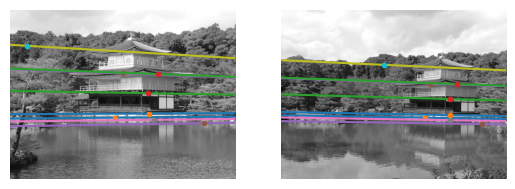

leafsB.jpg :  0.5851851851851851
number of inliers: 79 / 135


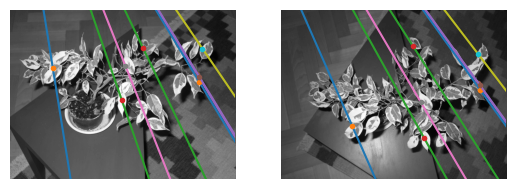

plantB.png :  0.6494252873563219
number of inliers: 113 / 174


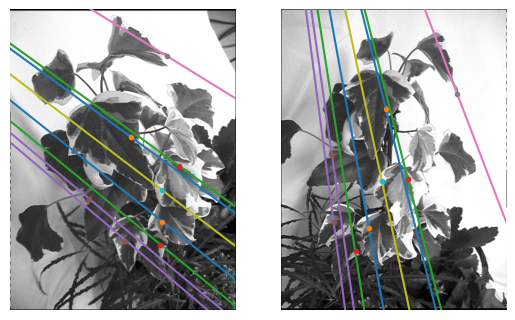

rotundaB.png :  0.782608695652174
number of inliers: 18 / 23


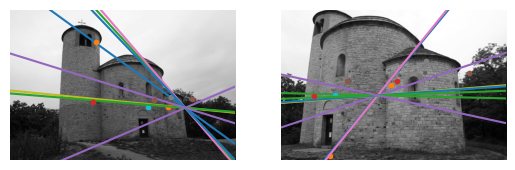

shoutB.png :  0.8198198198198198
number of inliers: 91 / 111


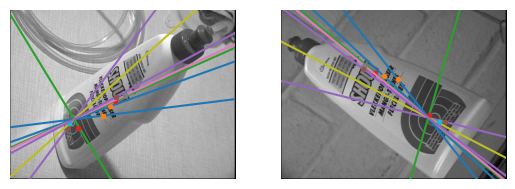

valbonneB.png :  0.917910447761194
number of inliers: 123 / 134


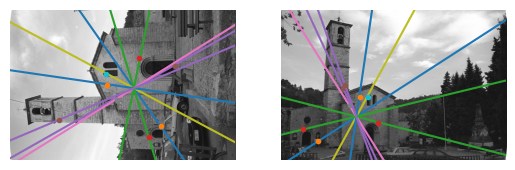

wallB.jpg :  0.908256880733945
number of inliers: 198 / 218


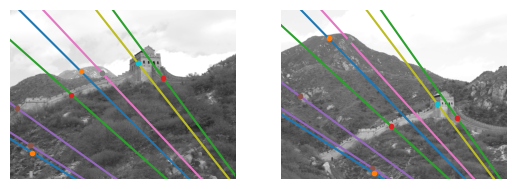

washB.png :  0.5084745762711864
number of inliers: 30 / 59


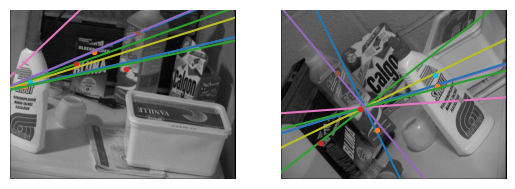

zoomB.png :  0.8688524590163934
number of inliers: 159 / 183


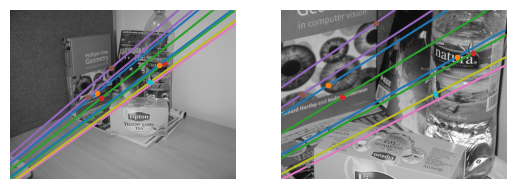

In [9]:
# test threshold of 0.002
result_norm_002 = ransac(kpL,kpR, thres=0.002)

bookshB.png :  0.9554140127388535
number of inliers: 150 / 157


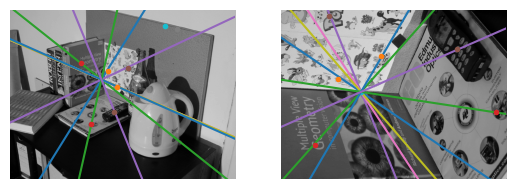

boxB.png :  0.9444444444444444
number of inliers: 170 / 180


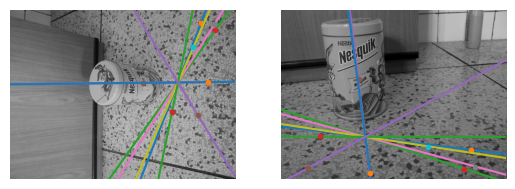

castleB.png :  0.8333333333333334
number of inliers: 165 / 198


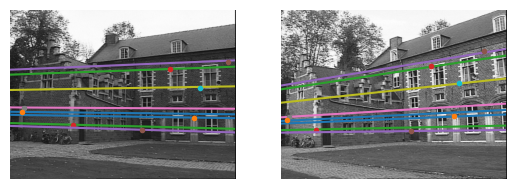

corrB.png :  0.9924242424242424
number of inliers: 393 / 396


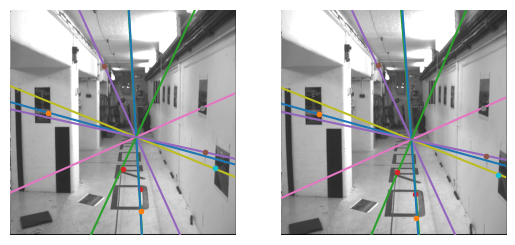

graffB.png :  0.4473684210526316
number of inliers: 17 / 38


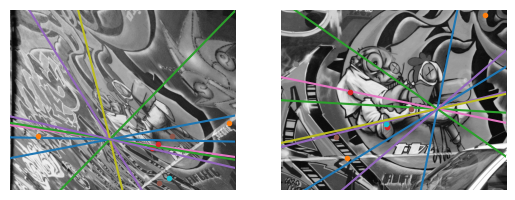

headB.jpg :  0.9283154121863799
number of inliers: 259 / 279


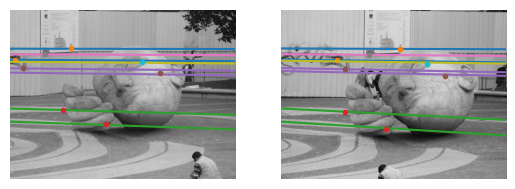

kampaB.png :  0.8656716417910447
number of inliers: 116 / 134


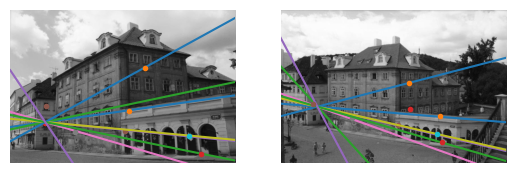

KyotoB.jpg :  0.9044056525353283
number of inliers: 1088 / 1203


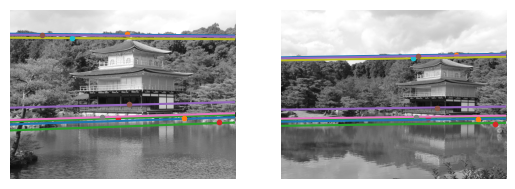

leafsB.jpg :  0.674074074074074
number of inliers: 91 / 135


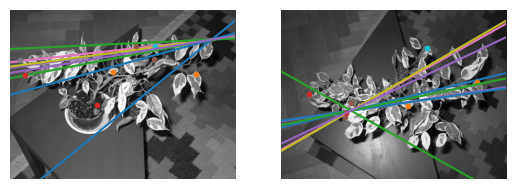

plantB.png :  0.7528735632183908
number of inliers: 131 / 174


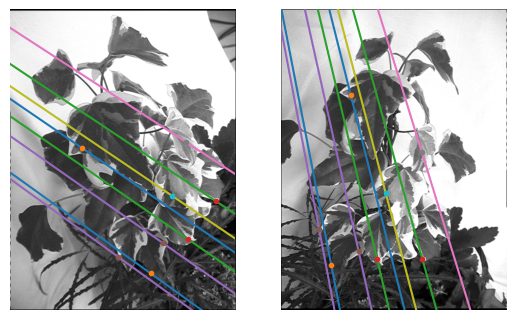

rotundaB.png :  0.8695652173913043
number of inliers: 20 / 23


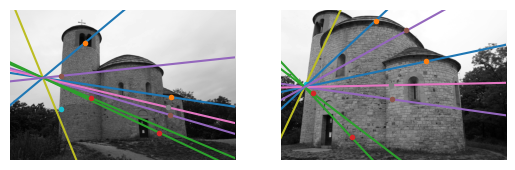

shoutB.png :  0.9279279279279279
number of inliers: 103 / 111


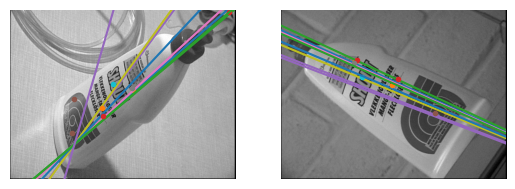

valbonneB.png :  0.9477611940298507
number of inliers: 127 / 134


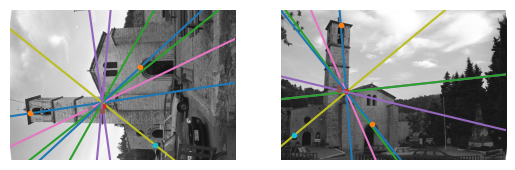

wallB.jpg :  0.926605504587156
number of inliers: 202 / 218


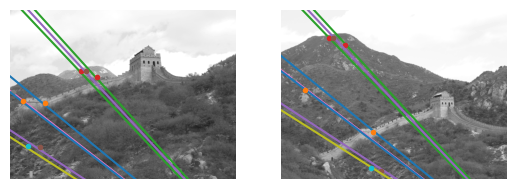

washB.png :  0.7288135593220338
number of inliers: 43 / 59


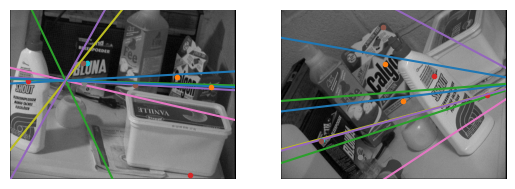

zoomB.png :  0.9016393442622951
number of inliers: 165 / 183


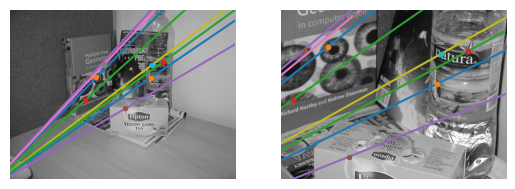

In [10]:
# test threshold of 0.005
result_norm_02 = ransac(kpL,kpR, thres=0.005)

In [12]:
# h. Re-estimate F using all the inliers.
for i in range(len(result_norm_002)):
    points, trans = normalise(kpL[i],kpR[i],img_pair[i][0])
    inliers_idx = result_norm_002[i][0]
    inliers = [points[i] for i in inliers_idx]
    F = design_matrix(inliers)
    inlier_num = 0
    for test_point in points:
        error = dist(test_point, F) 
        if error <= 0.002:
            inlier_num += 1
    print(names[i], ': ', inlier_num / len(points))

bookshB.png :  0.9363057324840764
boxB.png :  0.9055555555555556
castleB.png :  0.3333333333333333
corrB.png :  0.9873737373737373
graffB.png :  0.42105263157894735
headB.jpg :  0.9032258064516129
kampaB.png :  0.835820895522388
KyotoB.jpg :  0.8786367414796342
leafsB.jpg :  0.22962962962962963
plantB.png :  0.27011494252873564
rotundaB.png :  0.782608695652174
shoutB.png :  0.8468468468468469
valbonneB.png :  0.917910447761194
wallB.jpg :  0.7522935779816514
washB.png :  0.4915254237288136
zoomB.png :  0.8688524590163934


bookshB.png :  0.8152866242038217
number of inliers: 128 / 157


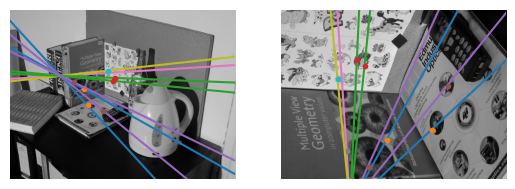

boxB.png :  0.8333333333333334
number of inliers: 150 / 180


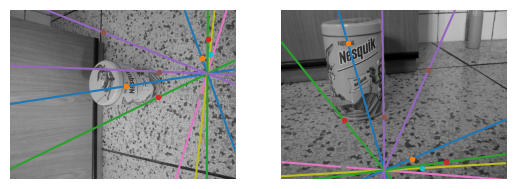

castleB.png :  0.22727272727272727
number of inliers: 45 / 198


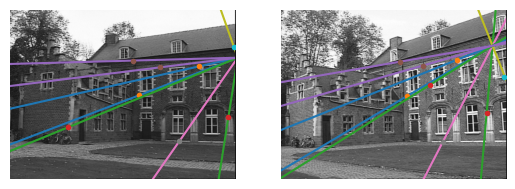

In [ ]:
# i. Compute F in terms of the original pixel coordinates
original = ransac(kpL,kpR,norm=False, thres=0.002)

### 3. Randomly sample 10 correspondences and display images, corresponding points and epipolar lines

In [ ]:
# plot image with 10 inliers
def go_plot(norm=True):
    for j in range(len(kpL)):
        if norm == True:
            check = result_norm_002[j]
        else:
            check = original[j]
        ptsL = np.array([kpL[j][i] for i in check[0]])
        ptsR = np.array([kpR[j][i] for i in check[0]])
        imgL, imgR = img_pair[j]
        F = check[1]
        if len(ptsL) >= 10:
            n_sample = 10
        else:
            n_sample = len(ptsL)-1
        x = np.random.choice(len(ptsL), n_sample, replace=False)

        pL = [ptsL[j] for j in x]
        pR = [ptsR[j] for j in x]
        plt.subplot(1,2,1)
        plot(imgL, F, pL, pR)
        plt.subplot(1,2,2)
        plot(imgR, F, pL, pR, False)
        plt.show()

In [ ]:
go_plot(True)

In [ ]:
go_plot(False)